# Figure 2

Code to generate plots for figure 2 of Nyquist et al 2022

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0,"../helper_functions")
import plotting_helpers as ph
import bm_data_functions as bm
import numpy as np
import seaborn as sns

In [2]:
import importlib
importlib.reload(bm)

<module 'bm_data_functions' from '../helper_functions/bm_data_functions.py'>

In [3]:
figure2_path = "../../Results/plots/figure_2/"


In [4]:
# This object is generated in the preprocessing_notebooks/09_combine_timepoint_subclustering.ipynb notebook
adata_no_doublets=sc.read_h5ad("../../Data/processed_data/all_timepoints/adata_no_doublets_FINAL.h5ad")


In [5]:
donor_colors = pd.read_csv("../helper_functions/donor_colors.csv")
donor_colors["num"]= donor_colors.index
donor_colors.index = donor_colors["donor"]

In [6]:
sample_meta = bm.get_bm_metadata()
sample_meta["milk stage ordered"] = [adata_no_doublets.obs.loc[adata_no_doublets.obs["sample"]==i,"milk stage ordered"][0] for i in sample_meta.index]
cols_of_interest=["milk stage ordered","donor",'infant_sick_YN', 'weaning_YN', 'mastisis_YN', 'breast_soreness_YN','directly_breastfeeding_YN', 'any_formula_YN','mother_medications_YN','reported_menstruating_YN', 'maternal_medical_event_YN',
                 'hormonal_birthcontrol_YN','daycare_YN', 'vaccines_reported_YN','solid_foods_YN']

In [7]:
ordered_samples =sample_meta["time_post_partum_days"].sort_values().index
numbered_df = pd.DataFrame(index=sample_meta.index, columns = cols_of_interest)
for c in cols_of_interest:
    numbered_df[c] = sample_meta[c].map(donor_colors["num"])
    
    
color_order = ['LC1','GPMNB macrophages', 'CSN1S1 macrophages',"neutrophils", "B cells", "T cells", "dendritic cells", "eosinophils", "fibroblasts",'LC2']


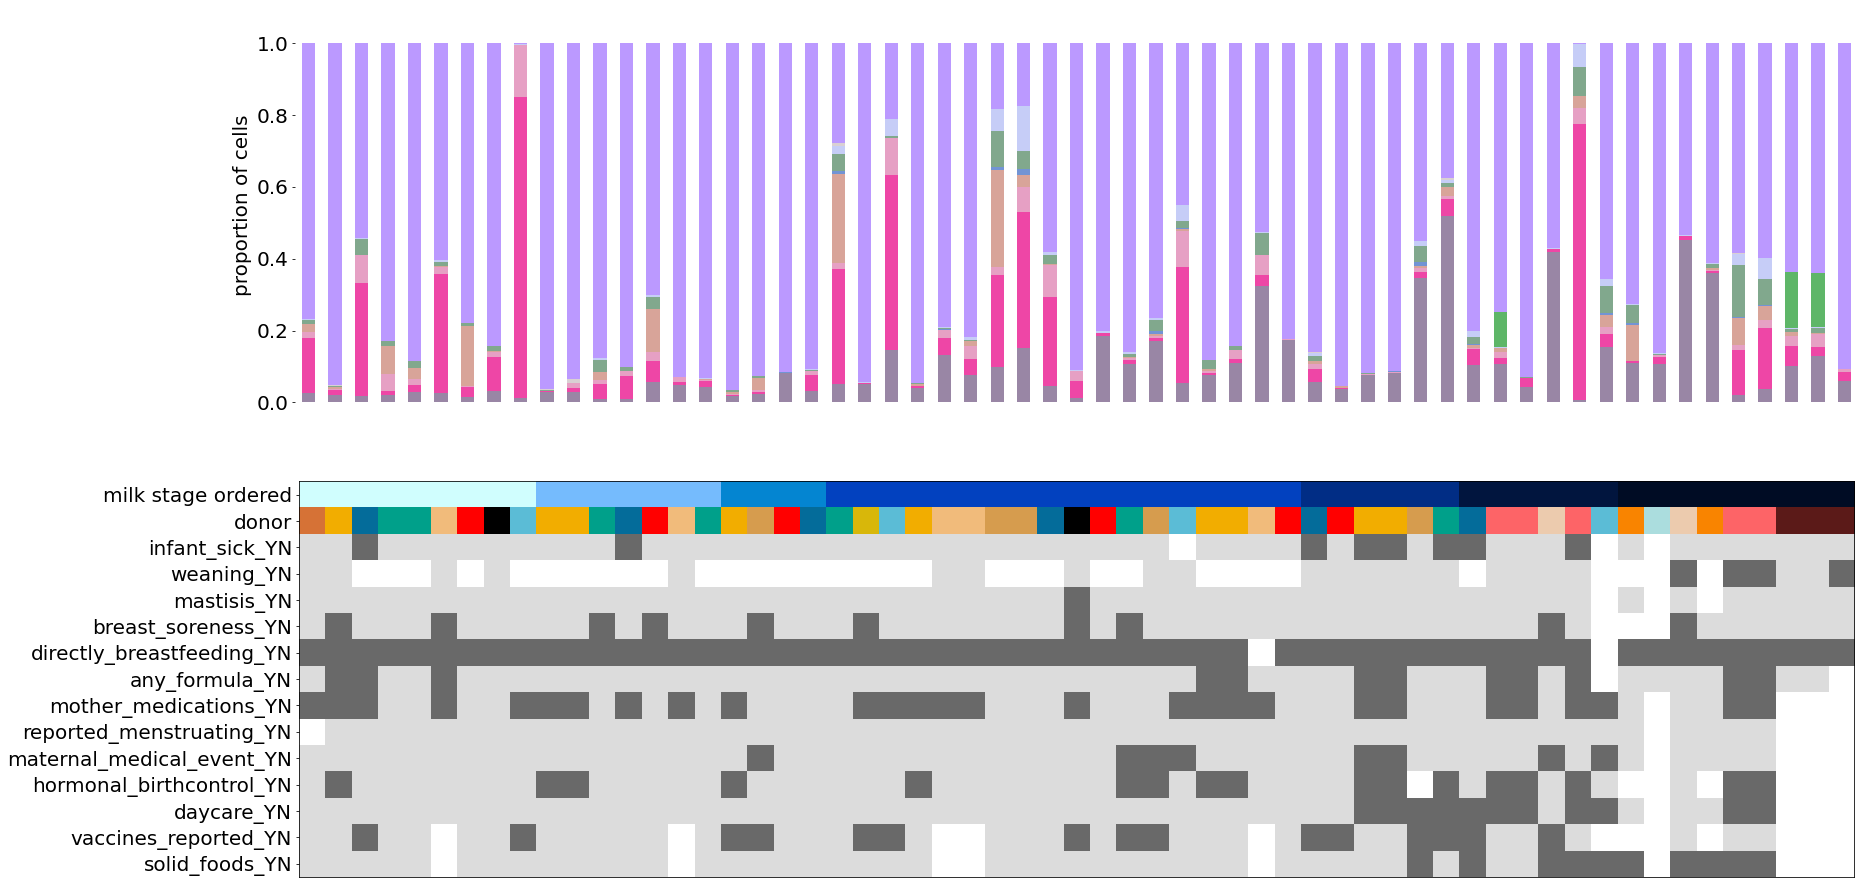

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.colors
plt.rcParams.update({'font.size': 20})
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(28,16))
# set up subplot grid
grid=gridspec.GridSpec(1,1)

gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = grid[0])
ax4 = fig.add_subplot(gs2[0])
#condition_plotting_helpers.grouped_stacked_bars(adata_no_doublets,plot_sep="milk stage ordered",x_value="donor",color_value="simplified celltypes")
ph.normalized_stacked_bar_plot(adata_no_doublets,"sample","simplified celltypes",legend=False, ax=ax4, x_order=ordered_samples,color_order=color_order)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.set_title("")
ax4.set_xlabel("")
ax5 = fig.add_subplot(gs2[1])
cmap = matplotlib.colors.ListedColormap(donor_colors["color"], name='colors', N=None)
plt.imshow(numbered_df.loc[ordered_samples].values.T,cmap=cmap)
plt.yticks(np.arange(0,numbered_df.shape[1]),labels=cols_of_interest)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig(figure2_path+"/Figure2A.pdf",bbox_inches="tight")

# annotations of significant associations are added manually and calculated in notebook GAM_differential_abundance_analysis.ipynb

In [9]:
cnts = adata_no_doublets.obs.groupby(["sample","simplified celltypes"]).count()["donor"].unstack()
props = cnts.divide(cnts.sum(axis=1),axis=0)

sample_meta_sub = sample_meta[sample_meta["time_post_partum_days"] < 400]

ordered_samples =sample_meta_sub["time_post_partum_days"].sort_values().index
   
    


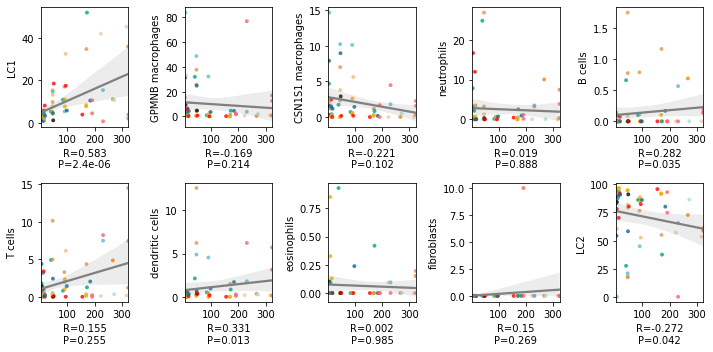

In [14]:
plt.rcParams.update({'font.size': 10})
props= props.fillna(0)
plt.figure(figsize=(10,5))
import numpy as np
import scipy.stats
for i,c in enumerate(color_order):
    plt.subplot(2,5,i+1)
    x=sample_meta_sub.loc[ordered_samples, "time_post_partum_days"]
    y= 100*props.loc[ordered_samples, c]
    sns.regplot(x=x,
               y=y,
               scatter_kws={"facecolors":[donor_colors.loc[d,"color"] for d in sample_meta_sub.loc[ordered_samples,"donor"]],
                           #"edgecolors":[donor_colors.loc[d,"color"] for d in sample_meta_sub.loc[ordered_samples,"donor"]],
                           "linewidths":0,
                            "s":15},
               line_kws={"color":"grey"})

    r,p=scipy.stats.spearmanr(x,y)
    plt.ylabel(c )
    if p < 0.01:
        plt.xlabel("R="+str(round(r,3))+"\n"+"P="+"{:.1e}".format(p) )
    else:
        plt.xlabel("R="+str(round(r,3))+"\n"+"P="+str(round(p,3)))
    
plt.tight_layout()
plt.savefig(figure2_path+"/Figure2B_proportions_over_time.pdf",bbox_inches="tight")